# This Notebook is for analyzing bird vocalizations. The vocalizations (or segments) were collected with wireless microphones and then segmented (either manually or with AI) to represent individual calls. 
## The expectation currently is that there are 4 simultaneous birds being recorded (4 channels). A lot of the analyses is based around finding individual peculiarities that are consistent under certain conditions. Any consistent deviations (for instance, in spectral structure of a given syllable) are promising potential ways in which the birds may be communicating with each other.
## We are also interested in revealing relationships between the birds, and personalities of the individual birds, by quantifying differences in their calling behaviors.


# TODO currently there are DCs in my tets trying to pull these out

In [1]:
# from scipy import integrate, optimize

from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
# from soundsig.sound import BioSound 
# from soundsig.sound import WavFile


# from ipywidgets import interact, fixed
# from ipywidgets import widgets
import matplotlib.pyplot as plt

def plot_a_spectrogram(w, fs:int=48000, title:str=spectrogram, nfft:int=2048):
    ff, tt, Sxx = spectrogram(w, fs=fs, nfft=nfft)
    max_ff = 10000 # only plot the first 10kHz
    ff_index = np.where(ff < max_ff)
    ff = ff[ff_index]
    Sxx = Sxx[ff_index]

    plt.figure(figsize=(10, 5))
    plt.pcolormesh(tt, ff[:max_ff], Sxx[:max_ff], cmap='plasma', shading='auto')
    # plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='plasma', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()


In [2]:
# base_folder = '/Users/williamwood/Documents/Sound_Localization/for_soundsep/14-38-03_18-07-2023' # old folder
base_folder = "/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/"
fs = 48000 # TODO find where to import fs instead of hardcoding it
# Sound_Localization/for_soundsep/7_18_23__09_29_44'

In [3]:
file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
# file_name = os.path.join(base_folder,'_appdata','save','segments_exclude_short_gaps.csv')

print(file_name)

df = pd.read_csv(file_name, sep=',',header=0)        
print(f'Length of dataframe: {len(df)}')
print(f'Column names: {df.columns}')
print(f'Tags: {df["Tags"].unique()}')

/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv
Length of dataframe: 4344
Column names: Index(['Unnamed: 0', 'SourceName', 'SourceChannel', 'StartIndex', 'StopIndex',
       'Tags', 'cluster', 'coords'],
      dtype='object')
Tags: ['["8"]' '["tet"]' '["hat"]' '["2"]' '["call"]' '["3"]' '["WF"]' '["DC"]'
 '["-2"]']


### Let's rename some of the columns and create some new columns that will help us track the data
#### 'Tags' are typically the type of vocalization, but sometimes they are a note to the researcher (such as, this is interesting, look at it).

In [4]:
df['StartIndex'][0]/fs
# df['Tags'] = df['Tags'].apply(lambda x: x[2:-2]) # old technique doesn't work for all
# df.loc[df['Tags'] == '','Tags'] = 'tet' # replace empty tags with 'tet' (not perfect but ok)
df['Bird_ID'] = df['SourceName']
df['StartIndex_in_sec'] = df['StartIndex']/fs
df['EndIndex_in_sec'] = df['StopIndex']/fs

# make a new df column that is the length of the segment in seconds
df['length'] = (df['StopIndex']-df['StartIndex'])/fs

# print(df['Tags'].unique())
print(df['Bird_ID'].unique())
print(f'Columns: {df.columns}')
print(df[0:10])

['BroGre1354M' 'BluGre1214F' 'WhiWhi1541M' 'WhiWhi6607F']
Columns: Index(['Unnamed: 0', 'SourceName', 'SourceChannel', 'StartIndex', 'StopIndex',
       'Tags', 'cluster', 'coords', 'Bird_ID', 'StartIndex_in_sec',
       'EndIndex_in_sec', 'length'],
      dtype='object')
   Unnamed: 0   SourceName  SourceChannel  StartIndex  StopIndex     Tags  \
0           0  BroGre1354M              0      705034     709502    ["8"]   
1           1  BluGre1214F              2      739121     741816  ["tet"]   
2           2  BluGre1214F              2      773851     776369  ["hat"]   
3           3  BluGre1214F              2      844891     848558  ["tet"]   
4           4  BroGre1354M              0      910549     913839  ["tet"]   
5           5  BluGre1214F              2      915664     917825  ["tet"]   
6           6  BroGre1354M              0      938688     943405    ["8"]   
7           7  BluGre1214F              2      955388     958960  ["tet"]   
8           8  BluGre1214F        

In [5]:
print(df['Tags'].unique())
df

['["8"]' '["tet"]' '["hat"]' '["2"]' '["call"]' '["3"]' '["WF"]' '["DC"]'
 '["-2"]']


,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster,coords,Bird_ID,StartIndex_in_sec,EndIndex_in_sec,length
0,0,BroGre1354M,0,705034,709502,"[""8""]",0.0,[10.697502 9.804635 7.993754],BroGre1354M,14.688208,14.781292,0.093083
1,1,BluGre1214F,2,739121,741816,"[""tet""]",5.0,[10.666748 7.427887 3.884933],BluGre1214F,15.398354,15.454500,0.056146
2,2,BluGre1214F,2,773851,776369,"[""hat""]",1.0,[10.273127 5.794117 2.64628 ],BluGre1214F,16.121896,16.174354,0.052458
3,3,BluGre1214F,2,844891,848558,"[""tet""]",5.0,[10.74689 7.3378167 3.9408872],BluGre1214F,17.601896,17.678292,0.076396
4,4,BroGre1354M,0,910549,913839,"[""tet""]",4.0,[12.070142 6.447742 1.3894552],BroGre1354M,18.969771,19.038312,0.068542
...,...,...,...,...,...,...,...,...,...,...,...,...
4339,4339,WhiWhi1541M,3,297302736,297305283,"[""tet""]",4.0,[13.107664 6.9023438 3.5997097],WhiWhi1541M,6193.807000,6193.860062,0.053062
4340,4340,BluGre1214F,2,297324812,297329004,"[""tet""]",5.0,[13.785383 9.68441 4.2628775],BluGre1214F,6194.266917,6194.354250,0.087333
4341,4341,BluGre1214F,2,297367001,297371644,"[""tet""]",5.0,[13.857406 9.577206 4.476639],BluGre1214F,6195.145854,6195.242583,0.096729
4342,4342,BluGre1214F,2,298070022,298074525,"[""tet""]",5.0,[12.200228 8.624041 5.4423275],BluGre1214F,6209.792125,6209.885938,0.093812


## We will calculate spectral features and do some automatic identification of different call types in a bit, but first we can see how often the different birds overlap each other.
## Do some birds overlap other birds more often? Does this correlate with the relationship they have with that bird (mate vs competitor) 
## Do some birds get overlapped more often? Does this indicate they are more submissive?

In [6]:
# First we will make two new columns in the DF- whether eatch vocalization is overlapped by another, and whether it overlaps another
# We'll also make some lists of the birds that overlap and are overlapped

bird_1_overlaps = list()
bird_1_overlapped = list()
bird_2_overlaps = list()
bird_2_overlapped = list()
bird_3_overlaps = list()
bird_3_overlapped = list()
bird_4_overlaps = list()
bird_4_overlapped = list()

# add the birdname to the above lists
birdnames = [birdname for birdname in df['Bird_ID'].unique()]
bird_1_overlaps.append(birdnames[0])
bird_1_overlapped.append(birdnames[0])
bird_2_overlaps.append(birdnames[1])
bird_2_overlapped.append(birdnames[1])
bird_3_overlaps.append(birdnames[2])
bird_3_overlapped.append(birdnames[2])
bird_4_overlaps.append(birdnames[3])
bird_4_overlapped.append(birdnames[3])


df['overlap'] = ''
df['overlapped'] = ''
overlap_list =  list()
overlapped_list = list()
for i in range(len(df)):
    if i < len(df)-1:
        if df['StartIndex'][i+1] < df['StopIndex'][i]: 
            df['overlap'][i+1] = df['SourceName'][i]
            df['overlapped'][i] = df['SourceName'][i+1]
            overlapped_list.append(df['SourceName'][i])
            overlap_list.append(df['SourceName'][i+1])
            # find which bird is overlapping which to add to the bird overlap lists
            if df['SourceName'][i+1] == birdnames[0]:
                bird_1_overlaps.append(df['SourceName'][i])
            elif df['SourceName'][i+1] == birdnames[1]:
                bird_2_overlaps.append(df['SourceName'][i])
            elif df['SourceName'][i+1] == birdnames[2]:
                bird_3_overlaps.append(df['SourceName'][i])
            elif df['SourceName'][i+1] == birdnames[3]:
                bird_4_overlaps.append(df['SourceName'][i])
            else:
                print('Error: no bird name found for overlapping bird')
            if df['SourceName'][i] == birdnames[0]:
                bird_1_overlapped.append(df['SourceName'][i+1])
            elif df['SourceName'][i] == birdnames[1]:
                bird_2_overlapped.append(df['SourceName'][i+1])
            elif df['SourceName'][i] == birdnames[2]:
                bird_3_overlapped.append(df['SourceName'][i+1])
            elif df['SourceName'][i] == birdnames[3]:
                bird_4_overlapped.append(df['SourceName'][i+1])
            else:
                print('Error: no bird name found for overlapped bird')






/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_4842/3049166442.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overlap'][i+1] = df['SourceName'][i]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_4842/3049166442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overlapped'][i] = df['SourceName'][i+1]


In [7]:
# How many tets does each bird produce? Let's plot it as a bar graph
summary_df = pd.DataFrame()
# count the number of vocalizations for each bird
summary_df['Bird_ID'] = df['Bird_ID'].unique()
summary_df['Number_of_vocalizations'] = df['Bird_ID'].value_counts().values
# count the number of vocalizations that each bird overlaps
summary_df['Number_of_overlaps'] = 0
summary_df['Number_of_overlapped'] = 0
summary_df['Number_of_overlaps'][0] = len(bird_1_overlaps)
summary_df['Number_of_overlaps'][1] = len(bird_2_overlaps)
summary_df['Number_of_overlaps'][2] = len(bird_3_overlaps)
summary_df['Number_of_overlaps'][3] = len(bird_4_overlaps)
summary_df['Number_of_overlapped'][0] = len(bird_1_overlapped)
summary_df['Number_of_overlapped'][1] = len(bird_2_overlapped)
summary_df['Number_of_overlapped'][2] = len(bird_3_overlapped)
summary_df['Number_of_overlapped'][3] = len(bird_4_overlapped)

# count the number of tets that each bird produces
summary_df['Number_of_tets'] = 0
summary_df['Number_of_dcs'] = 0
summary_df['Number_of_hats'] = 0
for bird in birdnames:
    tet_count = 0
    dc_count = 0
    hat_count = 0
    for i in range(len(df)):
        if df['Bird_ID'][i] == bird:
            if df['Tags'][i] == '["tet"]':
                tet_count += 1
            elif df['Tags'][i] == '["DC"]':
                dc_count += 1
            elif df['Tags'][i] == '["hat"]':
                hat_count += 1
    summary_df['Number_of_tets'][summary_df['Bird_ID'] == bird] = tet_count
    summary_df['Number_of_dcs'][summary_df['Bird_ID'] == bird] = dc_count


summary_df


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_4842/668286807.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df['Number_of_overlaps'][0] = len(bird_1_overlaps)
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_4842/668286807.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df['Number_of_overlaps'][1] = len(bird_2_overlaps)
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_4842/668286807.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,Bird_ID,Number_of_vocalizations,Number_of_overlaps,Number_of_overlapped,Number_of_tets,Number_of_dcs,Number_of_hats
0,BroGre1354M,1676,113,130,625,232,0
1,BluGre1214F,1226,149,112,1506,0,0
2,WhiWhi1541M,792,63,80,544,1,0
3,WhiWhi6607F,650,107,110,693,0,0


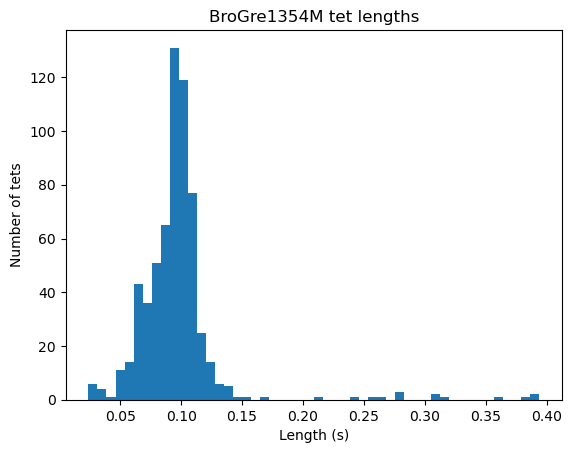

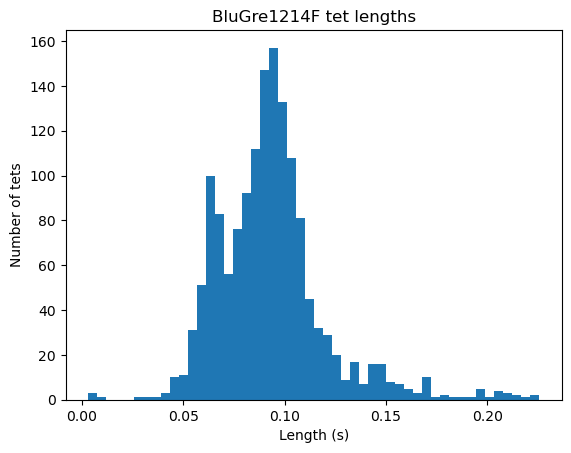

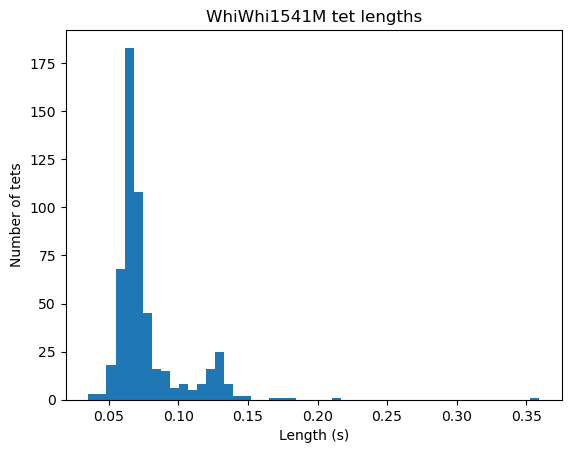

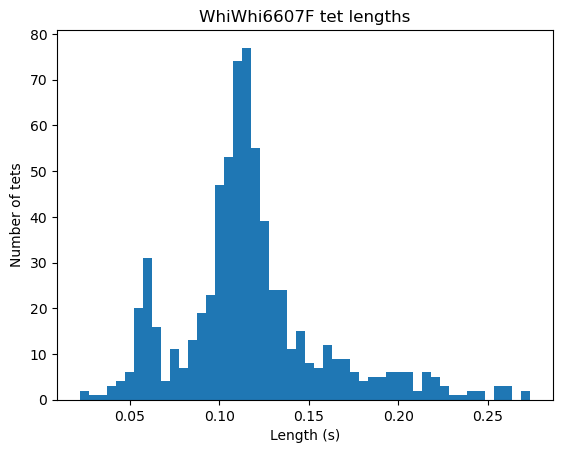

In [8]:
# what is the average length of a tet for each bird? Actually plot the distribution of tet lengths for each bird
tet_lengths = list()
for bird in birdnames:
    tet_lengths = list()
    for i in range(len(df)):
        if df['Bird_ID'][i] == bird:
            if df['Tags'][i] == '["tet"]':
                tet_lengths.append(df['length'][i])
    plt.hist(tet_lengths, bins=50)
    plt.title(f'{bird} tet lengths')
    plt.xlabel('Length (s)')
    plt.ylabel('Number of tets')
    plt.show()

### these are weird pie charts I don't know why I'm making this add up to 100- at the least it seems like it should be
### normalized for how often a bird vocalizes?

bird_1 (BroGre1354M): Counter({'BluGre1214F': 48, 'WhiWhi6607F': 37, 'WhiWhi1541M': 27})


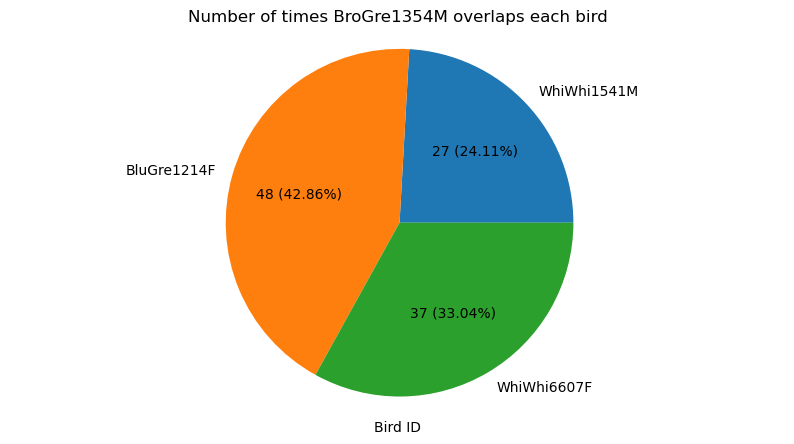

bird_2 (BluGre1214F): Counter({'BroGre1354M': 59, 'WhiWhi6607F': 56, 'WhiWhi1541M': 33})


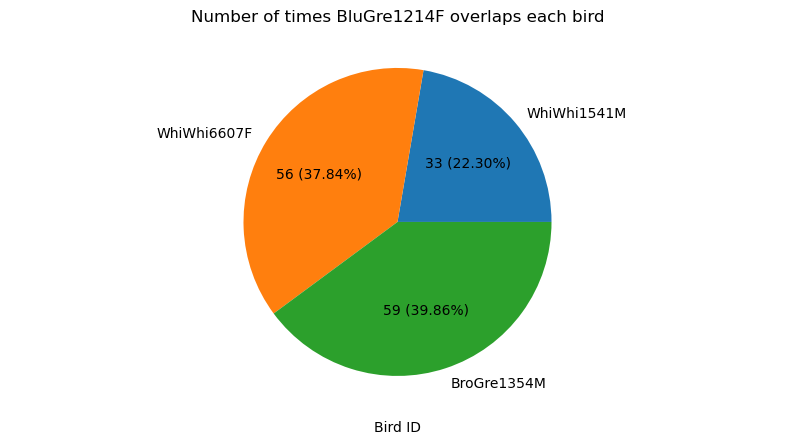

bird_3 (WhiWhi1541M): Counter({'BroGre1354M': 27, 'BluGre1214F': 19, 'WhiWhi6607F': 16})


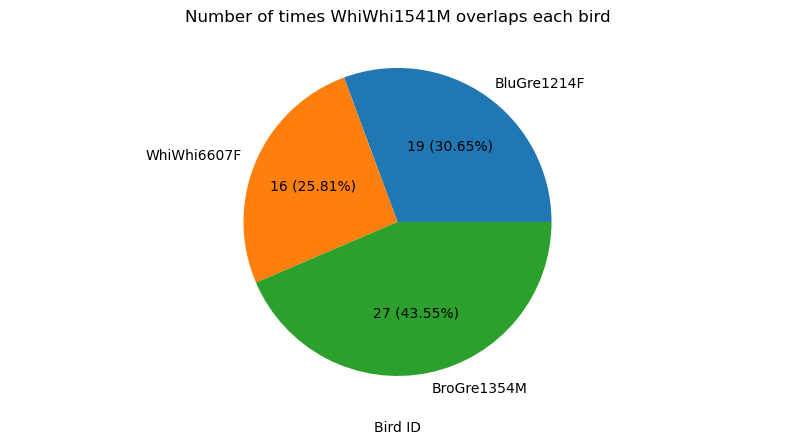

bird_4 (WhiWhi6607F): Counter({'BluGre1214F': 44, 'BroGre1354M': 43, 'WhiWhi1541M': 19})


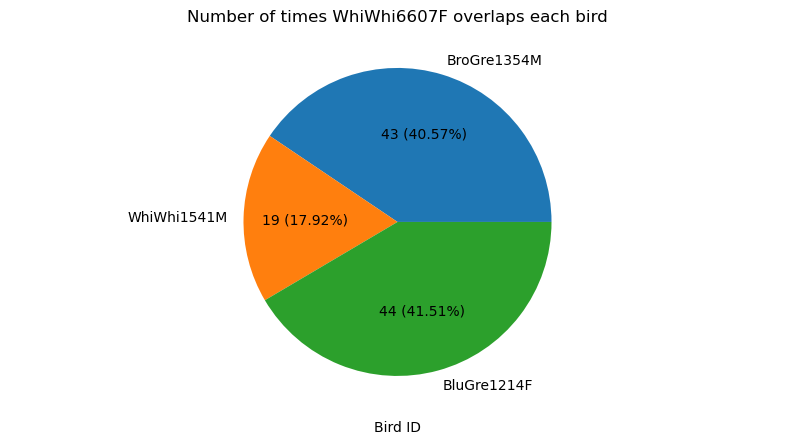

In [9]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d} ({p:.2f}%)'.format(p=pct,v=val)
    return my_autopct


print(f'bird_1 ({bird_1_overlaps[0]}): {Counter(bird_1_overlaps[1:])}')
# make a pie chart of the above data

plt.figure(figsize=(10, 5))
values = Counter(bird_1_overlaps[1:]).values()
labels = Counter(bird_1_overlaps[1:]).keys()
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.axis('equal')
plt.title(f'Number of times {bird_1_overlaps[0]} overlaps each bird')
plt.xlabel('Bird ID')
plt.show()

print(f'bird_2 ({bird_2_overlaps[0]}): {Counter(bird_2_overlaps[1:])}')
# make a pie chart of the above data
plt.figure(figsize=(10, 5))
values = Counter(bird_2_overlaps[1:]).values()
labels = Counter(bird_2_overlaps[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_2_overlaps[0]} overlaps each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()

print(f'bird_3 ({bird_3_overlaps[0]}): {Counter(bird_3_overlaps[1:])}')
# make a pie chart of the above data, and print the raw numbers on the pie chart
plt.figure(figsize=(10, 5))
values = Counter(bird_3_overlaps[1:]).values()
labels = Counter(bird_3_overlaps[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_3_overlaps[0]} overlaps each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()

print(f'bird_4 ({bird_4_overlaps[0]}): {Counter(bird_4_overlaps[1:])}')
# make a pie chart of the above data
plt.figure(figsize=(10, 5))
values = Counter(bird_4_overlaps[1:]).values()
labels = Counter(bird_4_overlaps[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_4_overlaps[0]} overlaps each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()





# print(f'bird_3 ({bird_3_overlaps[0]}): {Counter(bird_3_overlaps[1:])}')
# # make a pie chart of the above data, and print the raw numbers on the pie chart
# plt.figure(figsize=(10, 5))

# plt.pie(Counter(bird_3_overlaps[1:]).values(), labels=Counter(bird_3_overlaps[1:]).keys())


# plt.title(f'Number of times {bird_3_overlaps[0]} overlaps each bird')
# plt.xlabel('Bird ID')

# print(f'bird_4 ({bird_4_overlaps[0]}): {Counter(bird_4_overlaps[1:])}')
# # make a pie chart of the above data
# plt.figure(figsize=(10, 5))
# plt.pie(Counter(bird_4_overlaps[1:]).values(), labels=Counter(bird_4_overlaps[1:]).keys())
# plt.title(f'Number of times {bird_4_overlaps[0]} overlaps each bird')
# plt.xlabel('Bird ID')


Text(0.5, 1.0, 'Number of times each bird calls')

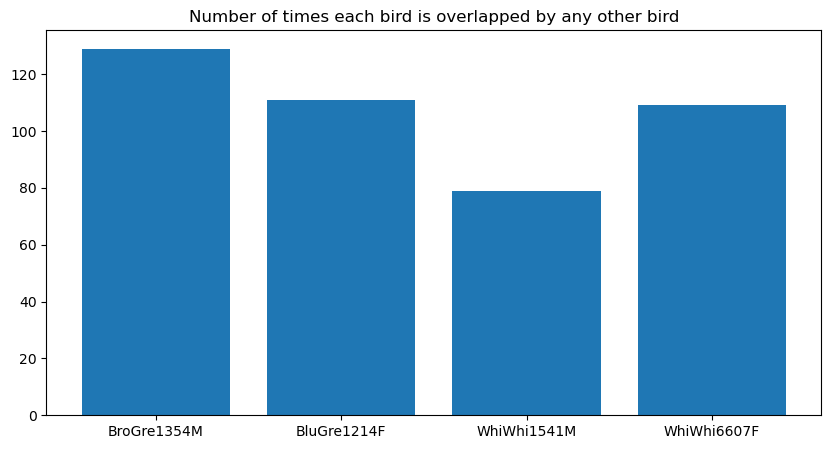

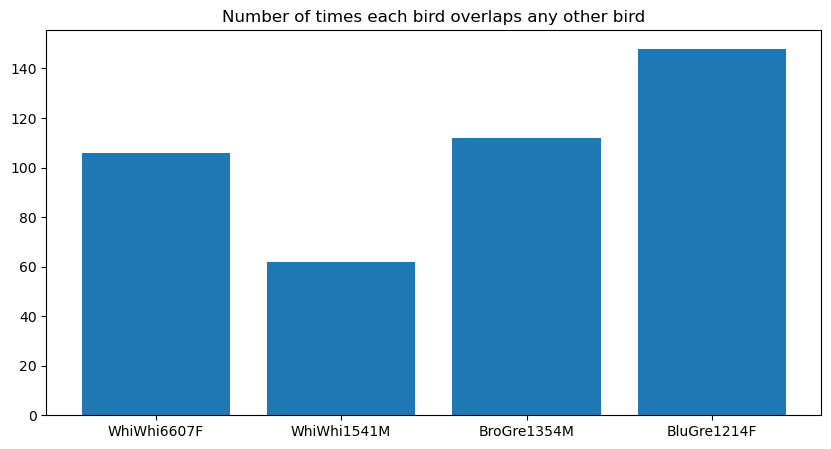

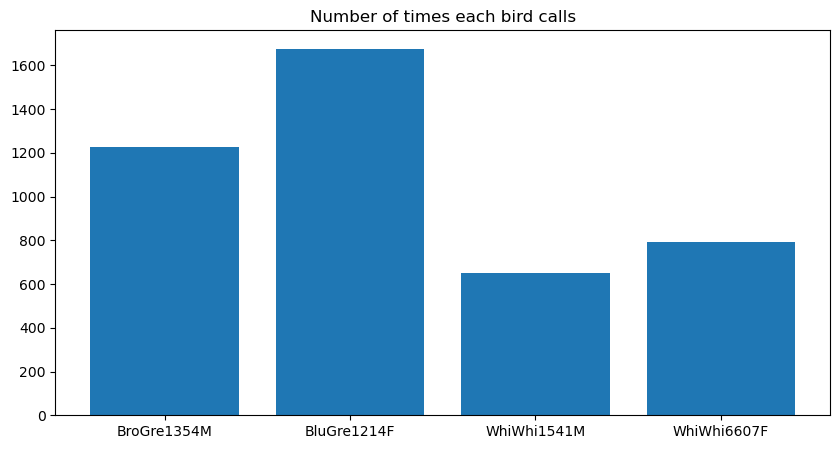

In [10]:
# number of times each bird is overlapped by any other bird, plotted as a bar graph
plt.figure(figsize=(10, 5))
values = Counter(overlapped_list).values()
labels = Counter(overlapped_list).keys()
plt.bar(labels, values)
plt.title('Number of times each bird is overlapped by any other bird')

# number of times each bird overlaps any other bird, plotted as a bar graph
plt.figure(figsize=(10, 5))
values = Counter(overlap_list).values()
labels = Counter(overlap_list).keys()
plt.bar(labels, values)
plt.title('Number of times each bird overlaps any other bird')

# number of times each bird calls, plotted as a bar graph
plt.figure(figsize=(10, 5))
values = Counter(df['Bird_ID']).values()
labels = Counter(df['Bird_ID']).keys()
plt.bar(labels, values)
plt.title('Number of times each bird calls')



In [20]:
call_nums = Counter(df['Bird_ID']).values()
labels = Counter(df['Bird_ID']).keys()
print(f'call_nums: {call_nums}')
print(f'labels: {labels}')
call_nums["BluGre1214F"]


call_nums: dict_values([1226, 1676, 650, 792])
labels: dict_keys(['BroGre1354M', 'BluGre1214F', 'WhiWhi1541M', 'WhiWhi6607F'])


TypeError: 'dict_values' object is not subscriptable

In [11]:
# in looking at how many times a bird overlaps or is overlapped, we need to keep in mind the number of vocalizations each bird makes, and control for that
# the simplest, imperfect way to do this, is we can do this by calculating the percentage of vocalizations that overlap or are overlapped for each bird
# we can then plot this as a bar graph


# maybe make that a dict
for i, bird in enumerate(labels):
    total_calls = Counter(df['Bird_ID'][bird]).values()
    summary_df['Number_of_vocalizations'][summary_df['Bird_ID'] == bird] = call_nums[i]

# summary_df['Overlap_percentage'] = summary_df['Number_of_overlaps']/summary_df['Number_of_vocalizations']*100
# summary_df['Overlapped_percentage'] = summary_df['Number_of_overlapped']/summary_df['Number_of_vocalizations']*100
print(summary_df)
# lets make a new column in the summary_df that is the percentage of vocalizations that overlap or are overlapped


# summary_df['Overlap_percentage'] = summary_df['Number_of_overlaps']/summary_df['Number_of_vocalizations']*100
# summary_df['Overlapped_percentage'] = summary_df['Number_of_overlapped']/summary_df['Number_of_vocalizations']*100

plt.figure(figsize=(10, 5))
plt.bar(summary_df['Bird_ID'], summary_df['Overlap_percentage'])
plt.title('Percentage of vocalizations that overlap')
plt.xlabel('Bird ID')
plt.ylabel('Percentage of vocalizations that overlap')


TypeError: 'dict_values' object is not subscriptable

Text(0.5, 1.0, 'Percentage of times each bird is overlapped by any other bird')

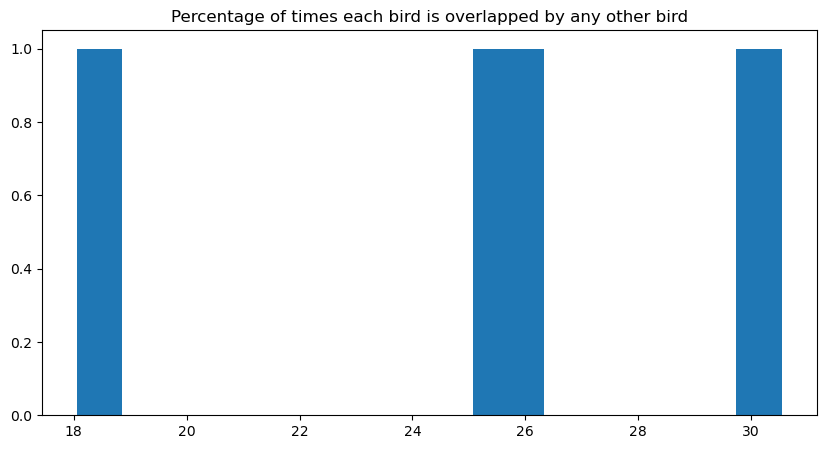

In [12]:
# percentage of times each bird is overlapped by any other bird, plotted as a bar graph
# convert the values to percentages

overlapped_list_percent = list(Counter(overlapped_list).values())
total = sum(overlapped_list_percent)
overlapped_list_percent = [i/total*100 for i in overlapped_list_percent]

# overlapped_list_percent = [i/sum(overlapped_list)*100 for i in overlapped_list]

plt.figure(figsize=(10, 5))
values = Counter(overlapped_list_percent).values()
labels = Counter(overlapped_list_percent).keys()
plt.bar(labels, values)
plt.title('Percentage of times each bird is overlapped by any other bird')





bird_1 (BroGre1354M): Counter({'BluGre1214F': 59, 'WhiWhi6607F': 43, 'WhiWhi1541M': 27})


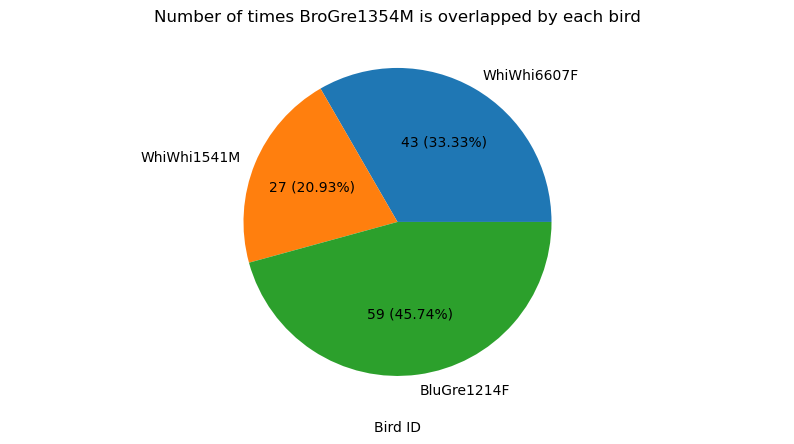

bird_2 (BluGre1214F): Counter({'BroGre1354M': 48, 'WhiWhi6607F': 44, 'WhiWhi1541M': 19})


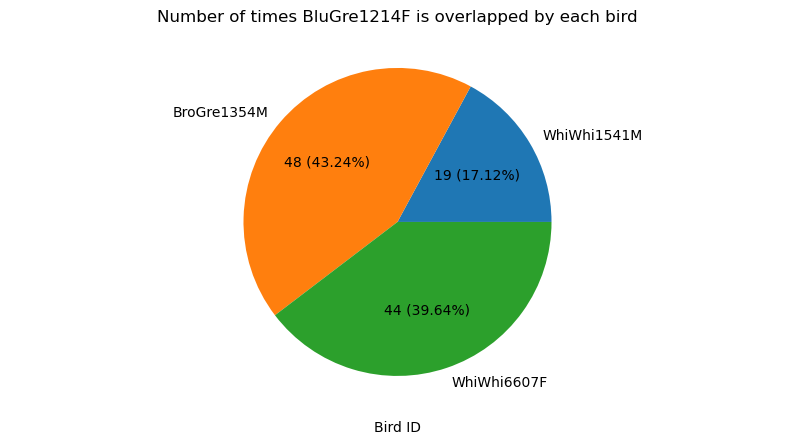

bird_3 (WhiWhi1541M): Counter({'BluGre1214F': 33, 'BroGre1354M': 27, 'WhiWhi6607F': 19})


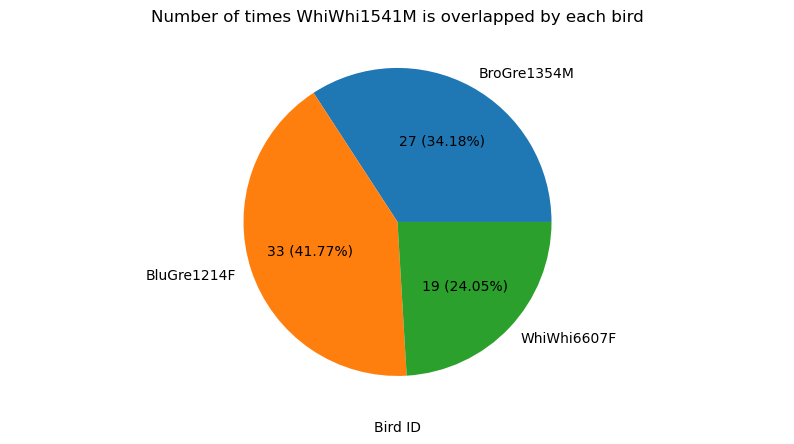

bird_4 (WhiWhi6607F): Counter({'BluGre1214F': 56, 'BroGre1354M': 37, 'WhiWhi1541M': 16})


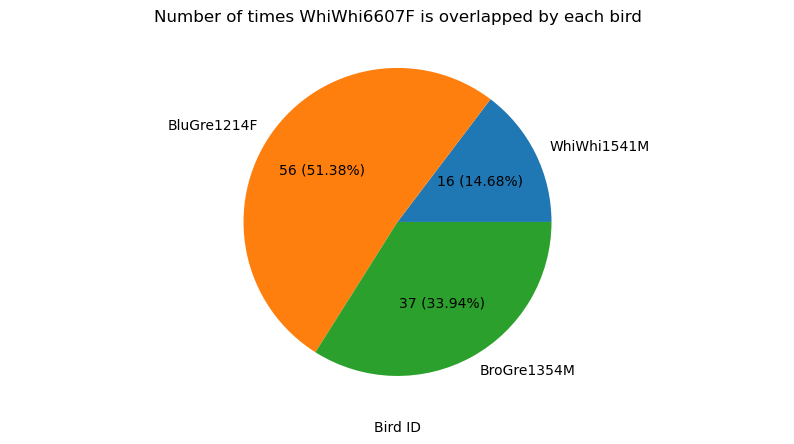

In [13]:
# Now how about how much each bird is overlapped by each bird?
print(f'bird_1 ({bird_1_overlapped[0]}): {Counter(bird_1_overlapped[1:])}')
# make a pie chart of the above data
plt.figure(figsize=(10, 5))
values = Counter(bird_1_overlapped[1:]).values()
labels = Counter(bird_1_overlapped[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_1_overlapped[0]} is overlapped by each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()

print(f'bird_2 ({bird_2_overlapped[0]}): {Counter(bird_2_overlapped[1:])}')
# make a pie chart of the above data
plt.figure(figsize=(10, 5))
values = Counter(bird_2_overlapped[1:]).values()    
labels = Counter(bird_2_overlapped[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_2_overlapped[0]} is overlapped by each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()

print(f'bird_3 ({bird_3_overlapped[0]}): {Counter(bird_3_overlapped[1:])}')
# make a pie chart of the above data
plt.figure(figsize=(10, 5))
values = Counter(bird_3_overlapped[1:]).values()
labels = Counter(bird_3_overlapped[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_3_overlapped[0]} is overlapped by each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()

print(f'bird_4 ({bird_4_overlapped[0]}): {Counter(bird_4_overlapped[1:])}')
# make a pie chart of the above data
plt.figure(figsize=(10, 5))
values = Counter(bird_4_overlapped[1:]).values()
labels = Counter(bird_4_overlapped[1:]).keys()
plt.axis('equal')
plt.title(f'Number of times {bird_4_overlapped[0]} is overlapped by each bird')
plt.pie(values, labels=labels, autopct=make_autopct(values))
plt.xlabel('Bird ID')
plt.show()


### Ok now let's look at responses instead of overlaps. Same general idea though

In [14]:
# calculate whether another segment starts within 1 second of the end of each segment
# and add this to the dataframe
df['overlap_start'] = ''
df['overlap_end'] = ''
bird_1_answered_by = list() # list of birds that respond to bird 1
bird_1_responds_to = list() # list of birds that bird 1 responds to
bird_2_answered_by = list() # list of birds that respond to bird 2
bird_2_responds_to = list() # list of birds that bird 2 responds to
bird_3_answered_by = list() # list of birds that respond to bird 3
bird_3_responds_to = list() # list of birds that bird 3 responds to
bird_4_answered_by = list() # list of birds that respond to bird 4
bird_4_responds_to = list() # list of birds that bird 4 responds to

bird_1_answered_by.append(birdnames[0])
bird_1_responds_to.append(birdnames[0])
bird_2_answered_by.append(birdnames[1])
bird_2_responds_to.append(birdnames[1])
bird_3_answered_by.append(birdnames[2])
bird_3_responds_to.append(birdnames[2])
bird_4_answered_by.append(birdnames[3])
bird_4_responds_to.append(birdnames[3])



response_interval = 1.0 # seconds # TODO make this a variable that is passed in or something
df['answered_by'] = ''
df['responds_to'] = ''
for i in range(len(df)):
    if i < len(df)-1:
        if df['StartIndex'][i+1] < ( df['StopIndex'][i] + response_interval * fs): 
            df['responds_to'][i+1] = df['SourceName'][i] # TODO make this a zip also containing the call type it responds to?
            df['answered_by'][i] = df['SourceName'][i+1] # TODO make this a zip also containing the call type that responds to it?
            # find which bird is overlapping which to add to the bird overlap lists
            if df['SourceName'][i+1] == birdnames[0]:
                bird_1_responds_to.append(df['SourceName'][i])
            elif df['SourceName'][i+1] == birdnames[1]:
                bird_2_responds_to.append(df['SourceName'][i])
            elif df['SourceName'][i+1] == birdnames[2]:
                bird_3_responds_to.append(df['SourceName'][i])
            elif df['SourceName'][i+1] == birdnames[3]:
                bird_4_responds_to.append(df['SourceName'][i])
            else:
                print('Error: no bird name found for overlapping bird')
            if df['SourceName'][i] == birdnames[0]:
                bird_1_answered_by.append(df['SourceName'][i+1])
            elif df['SourceName'][i] == birdnames[1]:
                bird_2_answered_by.append(df['SourceName'][i+1])
            elif df['SourceName'][i] == birdnames[2]:
                bird_3_answered_by.append(df['SourceName'][i+1])
            elif df['SourceName'][i] == birdnames[3]:
                bird_4_answered_by.append(df['SourceName'][i+1])
            else:
                print('Error: no bird name found for overlapped bird')

print(f'bird_1: ({bird_1_responds_to[0]}) responds to: {Counter(bird_1_responds_to[1:])}')
print(f'{bird_1_answered_by[0]}) is answered by: {Counter(bird_1_answered_by[1:])}')
print(f'bird_2: ({bird_2_responds_to[0]}) responds to: {Counter(bird_2_responds_to[1:])}')
print(f'{bird_2_answered_by[0]}) is answered by: {Counter(bird_2_answered_by[1:])}')
print(f'bird_3: ({bird_3_responds_to[0]}) responds to: {Counter(bird_3_responds_to[1:])}')
print(f'{bird_3_answered_by[0]}) is answered by: {Counter(bird_3_answered_by[1:])}')
print(f'bird_4: ({bird_4_responds_to[0]}) responds to: {Counter(bird_4_responds_to[1:])}')
print(f'{bird_4_answered_by[0]}) is answered by: {Counter(bird_4_answered_by[1:])}')


# First count the number of responses from each bird to each bird to make the weights for the social network
bird_1_response_weights = Counter(bird_1_responds_to[1:])
bird_2_response_weights = Counter(bird_2_responds_to[1:])
bird_3_response_weights = Counter(bird_3_responds_to[1:])
bird_4_response_weights = Counter(bird_4_responds_to[1:])
# Then count the number of times each bird is responded to by each bird to make the weights
bird_1_answer_weights = Counter(bird_1_answered_by[1:])
bird_2_answer_weights = Counter(bird_2_answered_by[1:])
bird_3_answer_weights = Counter(bird_3_answered_by[1:])
bird_4_answer_weights = Counter(bird_4_answered_by[1:])





bird_1: (BroGre1354M) responds to: Counter({'BluGre1214F': 419, 'WhiWhi6607F': 216, 'BroGre1354M': 154, 'WhiWhi1541M': 147})
BroGre1354M) is answered by: Counter({'BluGre1214F': 466, 'WhiWhi6607F': 261, 'BroGre1354M': 154, 'WhiWhi1541M': 111})
bird_2: (BluGre1214F) responds to: Counter({'BroGre1354M': 466, 'BluGre1214F': 439, 'WhiWhi6607F': 275, 'WhiWhi1541M': 206})
BluGre1214F) is answered by: Counter({'BluGre1214F': 439, 'BroGre1354M': 419, 'WhiWhi1541M': 250, 'WhiWhi6607F': 245})
bird_3: (WhiWhi1541M) responds to: Counter({'BluGre1214F': 250, 'BroGre1354M': 111, 'WhiWhi6607F': 82, 'WhiWhi1541M': 78})
WhiWhi1541M) is answered by: Counter({'BluGre1214F': 206, 'BroGre1354M': 147, 'WhiWhi6607F': 82, 'WhiWhi1541M': 78})
bird_4: (WhiWhi6607F) responds to: Counter({'BroGre1354M': 261, 'BluGre1214F': 245, 'WhiWhi1541M': 82, 'WhiWhi6607F': 52})
WhiWhi6607F) is answered by: Counter({'BluGre1214F': 275, 'BroGre1354M': 216, 'WhiWhi1541M': 82, 'WhiWhi6607F': 52})


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_7890/1015159970.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['responds_to'][i+1] = df['SourceName'][i] # TODO make this a zip also containing the call type it responds to?
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_7890/1015159970.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['answered_by'][i] = df['SourceName'][i+1] # TODO make this a zip also containing the call type that responds to it?


### Let's make a social netwrk graph of who responds to who


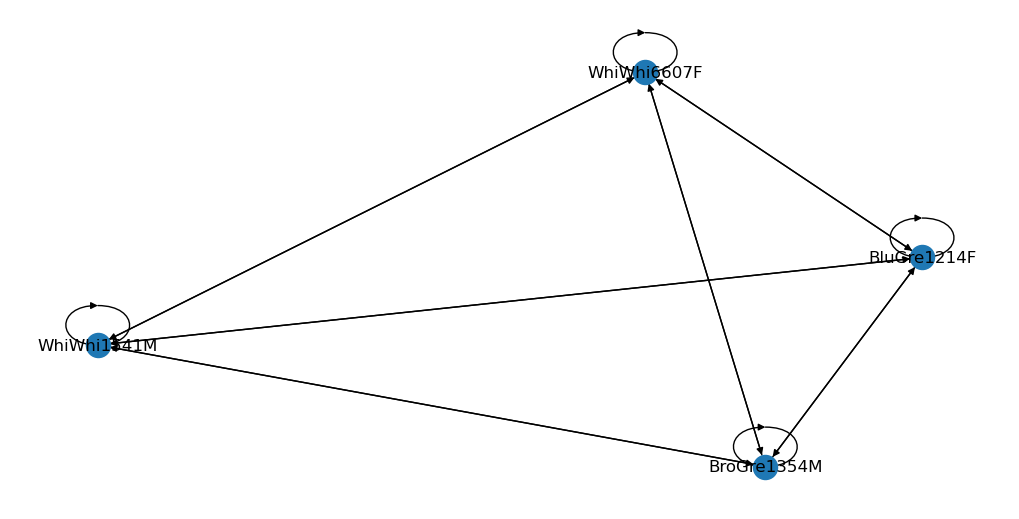

In [15]:
# We need to use a directed graph
# And make the nodes the bird names
# And make the edges the responses, weighted by the number of responses




import networkx as nx
# G = nx.Graph()
G = nx.DiGraph()
G.add_nodes_from(birdnames)

G.add_weighted_edges_from([(bird_1_responds_to[0], x,y) for x,y in bird_1_response_weights.items()])
G.add_weighted_edges_from([(bird_2_responds_to[0], x,y) for x,y in bird_2_response_weights.items()])
G.add_weighted_edges_from([(bird_3_responds_to[0], x,y) for x,y in bird_3_response_weights.items()])
G.add_weighted_edges_from([(bird_4_responds_to[0], x,y) for x,y in bird_4_response_weights.items()])
G.add_weighted_edges_from([(x, bird_1_answered_by[0],y) for x,y in bird_1_answer_weights.items()])
G.add_weighted_edges_from([(x, bird_2_answered_by[0],y) for x,y in bird_2_answer_weights.items()])
G.add_weighted_edges_from([(x, bird_3_answered_by[0],y) for x,y in bird_3_answer_weights.items()])
G.add_weighted_edges_from([(x, bird_4_answered_by[0],y) for x,y in bird_4_answer_weights.items()])



pos = nx.spring_layout(G)

# Now plot the graph
plt.figure(figsize=(10, 5))
nx.draw(G, with_labels=True)
# nx.draw_networkx(G, pos, width=edge_weights, with_labels=True, node_color='lightblue', node_size=500)

plt.show()








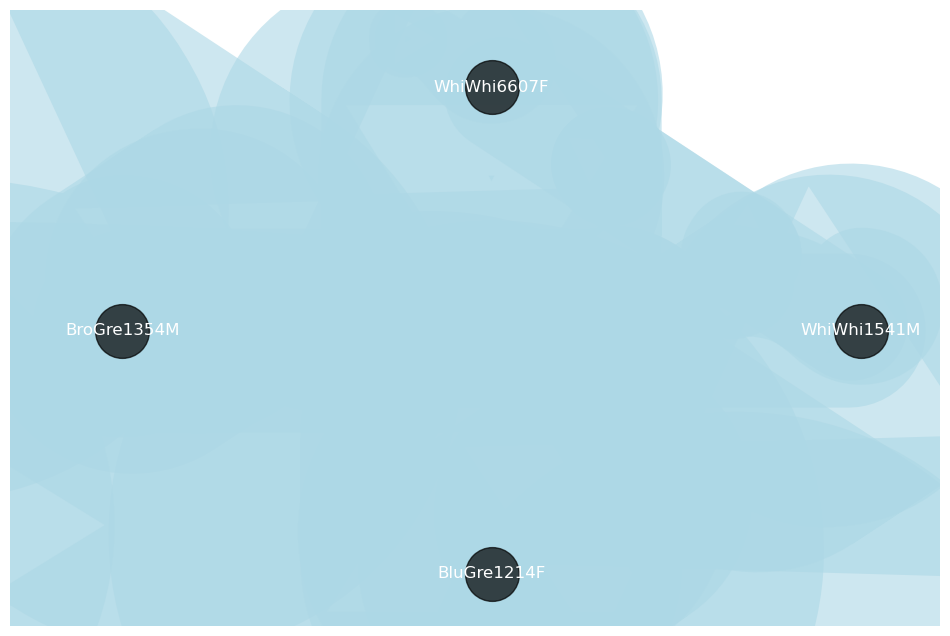

In [38]:


widths = nx.get_edge_attributes(G, 'weight')
# normalize my edge weights
# make a for list



nodelist = G.nodes()

plt.figure(figsize=(12,8))

pos = nx.shell_layout(G)
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=1500,
                       node_color='black',
                       alpha=0.7)
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       edge_color='lightblue',
                       alpha=0.6)
nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='white')
plt.box(False)
plt.show()

In [31]:
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(bird_1_answered_by)
G.add_nodes_from(bird_2_answered_by)

# Add edges with weights
for bird, weight in bird_1_answer_weights.items():
    G.add_edge(bird, bird_1_answered_by[bird], weight=weight)

for bird, weight in bird_2_answer_weights.items():
    G.add_edge(bird, bird_2_answered_by[bird], weight=weight)

# Set positions for nodes
pos = nx.spring_layout(G)

# Get edge weights
edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]

# Draw the graph
nx.draw_networkx(G, pos, width=edge_weights, with_labels=True, node_color='lightblue', node_size=500)

# Add edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

TypeError: list indices must be integers or slices, not str

## Ok Now I want to take a look at some spectral features. I want to start by trying to cluster the segments based on spectral-temporal features.

In [22]:
# Save the df as a csv and a pickle file
df.to_csv(os.path.join(base_folder,'_appdata','save','call_and_response_df.csv'))